In [1]:
import pandas as pd

archivo_csv = r'C:\Users\paula\OneDrive\Documentos\Facultad\Proyecto Final\informe_agenda_produccion.xlsx - datos.csv'
df = pd.read_csv(archivo_csv)

print(df.head())

     Nº Repetición|Ajuste             Cliente  Ctd  \
0  0051                 -       PEDRO MORALES   10   
1  0085                 -     ALAN SULIKOWSKI   20   
2  0085                 -     ALAN SULIKOWSKI   20   
3  0085                 -     ALAN SULIKOWSKI   20   
4  0099                 -  SANTIAGO BRAVERMAN    6   

                     Servicio    Sector              Etapa         Empleado  \
0              Encia Acrilica  ACRILICO             RESINA     NORMA JUNCAL   
1  Provisorio de PMMA Cad Cam   FRESADO               PMMA  LUCIANO TORIANI   
2  Provisorio de PMMA Cad Cam  ACRILICO        TERMINACION    DEMIAN SANTOS   
3  Provisorio de PMMA Cad Cam    DISEÑO            CORONAS    DEMIAN SANTOS   
4         Diseño 3D por Pieza    DISEÑO  DISEÑO DE SONRISA  LUCAS RODRIGUEZ   

                Início           Finalizado     Fecha entrada Fecha prevista  \
0  22/01/2024 16:05:00  22/01/2024 16:05:00  31/08/2023 12:12      8/11/2023   
1   8/03/2024 11:32:00  11/03/2024 10:46

In [2]:
df = df.iloc[:, :11 + 1] #Borre las columnas que le siguen a Tiempo Horas
print(df.columns)

Index(['Nº', 'Repetición|Ajuste', 'Cliente', 'Ctd', 'Servicio', 'Sector',
       'Etapa', 'Empleado', 'Início', 'Finalizado', 'Fecha entrada',
       'Fecha prevista'],
      dtype='object')


#### Agrego la columnas de Tiempo Neto contando con los horarios laborales (lunes a viernes, 8-18hrs)

In [3]:
# Agrego columna de Horas Tarea Neto

import pandas as pd
from datetime import timedelta

# Convertir las columnas 'Início' y 'Finalizado' a formato datetime
df['Início'] = pd.to_datetime(df['Início'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df['Finalizado'] = pd.to_datetime(df['Finalizado'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# Definir las horas de trabajo diarias
hora_inicio = 8
hora_fin = 18

# Función para calcular el tiempo trabajado entre 'Início' y 'Finalizado' considerando solo horas laborales
def calcular_tiempo_laboral(inicio, final):
    if pd.isnull(inicio) or pd.isnull(final):
        return pd.NaT
    
    # Si la fecha de inicio es mayor que la final, retornar 0
    if inicio >= final:
        return timedelta(0)

    total_tiempo = timedelta(0)
    current_time = inicio

    while current_time < final:
        # Saltar fines de semana
        if current_time.weekday() >= 5:  # Si es sábado (5) o domingo (6)
            current_time += timedelta(days=(7 - current_time.weekday()))  # Avanzar al próximo lunes
            current_time = current_time.replace(hour=hora_inicio, minute=0, second=0)
            continue
        
        # Ajustar el tiempo actual al horario laboral (8:00 a 18:00)
        if current_time.hour < hora_inicio:
            current_time = current_time.replace(hour=hora_inicio, minute=0, second=0)
        elif current_time.hour >= hora_fin:
            current_time += timedelta(days=1)
            current_time = current_time.replace(hour=hora_inicio, minute=0, second=0)
            continue

        # Calcular el fin del día laboral
        fin_dia_laboral = current_time.replace(hour=hora_fin, minute=0, second=0)
        if final < fin_dia_laboral:
            fin_dia_laboral = final

        # Agregar el tiempo trabajado en el día actual
        total_tiempo += fin_dia_laboral - current_time
        current_time = fin_dia_laboral

        # Pasar al siguiente día laboral
        current_time += timedelta(days=1)
        current_time = current_time.replace(hour=hora_inicio, minute=0, second=0)

    return total_tiempo

# Aplicar la función de cálculo de tiempo laboral a cada fila del DataFrame
df['Horas Tarea Neto'] = df.apply(lambda row: calcular_tiempo_laboral(row['Início'], row['Finalizado']), axis=1)

# Convertir 'Tiempo Horas' a formato 'HH:MM'
df['Horas Tarea Neto'] = df['Horas Tarea Neto'].apply(lambda x: f"{int(x.total_seconds() // 3600):02d}:{int((x.total_seconds() % 3600) // 60):02d}" if pd.notnull(x) else None)

# Mostrar el DataFrame con la nueva columna en formato 'HH:MM'
print(df.head())


     Nº Repetición|Ajuste             Cliente  Ctd  \
0  0051                 -       PEDRO MORALES   10   
1  0085                 -     ALAN SULIKOWSKI   20   
2  0085                 -     ALAN SULIKOWSKI   20   
3  0085                 -     ALAN SULIKOWSKI   20   
4  0099                 -  SANTIAGO BRAVERMAN    6   

                     Servicio    Sector              Etapa         Empleado  \
0              Encia Acrilica  ACRILICO             RESINA     NORMA JUNCAL   
1  Provisorio de PMMA Cad Cam   FRESADO               PMMA  LUCIANO TORIANI   
2  Provisorio de PMMA Cad Cam  ACRILICO        TERMINACION    DEMIAN SANTOS   
3  Provisorio de PMMA Cad Cam    DISEÑO            CORONAS    DEMIAN SANTOS   
4         Diseño 3D por Pieza    DISEÑO  DISEÑO DE SONRISA  LUCAS RODRIGUEZ   

               Início          Finalizado     Fecha entrada Fecha prevista  \
0 2024-01-22 16:05:00 2024-01-22 16:05:00  31/08/2023 12:12      8/11/2023   
1 2024-03-08 11:32:00 2024-03-11 10:46:00  2

In [4]:
# Agrego columnas de Minutos Tarea Neto y Dias Tarea Neto

# Función para convertir el formato 'HH:MM' a timedelta (duración en horas y minutos)
def convertir_horas_a_timedelta(horas_str):
    if pd.isnull(horas_str):
        return None
    horas, minutos = map(int, horas_str.split(':'))
    return timedelta(hours=horas, minutes=minutos)

# Convertir 'Horas Tarea Neto' a timedelta para su uso en los cálculos de minutos y días
df['Horas Tarea Neto (timedelta)'] = df['Horas Tarea Neto'].apply(convertir_horas_a_timedelta)

# Calcular 'Minutos Tarea Neto'
df['Minutos Tarea Neto'] = df['Horas Tarea Neto (timedelta)'].apply(lambda x: x.total_seconds() / 60 if pd.notnull(x) else None)

# Calcular 'Días Tarea Neto'
df['Días Tarea Neto'] = df['Horas Tarea Neto (timedelta)'].apply(lambda x: x.total_seconds() / (3600 * 24) if pd.notnull(x) else None)

# Eliminar la columna temporal 'Horas Tarea Neto (timedelta)'
df.drop(columns=['Horas Tarea Neto (timedelta)'], inplace=True)

# Mostrar el DataFrame con las nuevas columnas
print(df.head())

     Nº Repetición|Ajuste             Cliente  Ctd  \
0  0051                 -       PEDRO MORALES   10   
1  0085                 -     ALAN SULIKOWSKI   20   
2  0085                 -     ALAN SULIKOWSKI   20   
3  0085                 -     ALAN SULIKOWSKI   20   
4  0099                 -  SANTIAGO BRAVERMAN    6   

                     Servicio    Sector              Etapa         Empleado  \
0              Encia Acrilica  ACRILICO             RESINA     NORMA JUNCAL   
1  Provisorio de PMMA Cad Cam   FRESADO               PMMA  LUCIANO TORIANI   
2  Provisorio de PMMA Cad Cam  ACRILICO        TERMINACION    DEMIAN SANTOS   
3  Provisorio de PMMA Cad Cam    DISEÑO            CORONAS    DEMIAN SANTOS   
4         Diseño 3D por Pieza    DISEÑO  DISEÑO DE SONRISA  LUCAS RODRIGUEZ   

               Início          Finalizado     Fecha entrada Fecha prevista  \
0 2024-01-22 16:05:00 2024-01-22 16:05:00  31/08/2023 12:12      8/11/2023   
1 2024-03-08 11:32:00 2024-03-11 10:46:00  2

In [5]:
import pandas as pd
from datetime import timedelta

# Función para convertir la columna 'Horas Tarea Neto' de formato 'HH:MM' a timedelta
def convertir_horas_a_timedelta(horas_str):
    if pd.isnull(horas_str) or horas_str == '00:00':
        return timedelta(0)
    horas, minutos = map(int, horas_str.split(':'))
    return timedelta(hours=horas, minutes=minutos)

# Convertir 'Horas Tarea Neto' a timedelta para realizar sumas
df['Horas Tarea Neto (timedelta)'] = df['Horas Tarea Neto'].apply(convertir_horas_a_timedelta)

# Agrupar por número de pedido ('Nº Repetición|Ajuste') y sumar las horas, minutos y días
agrupado_pedido = df.groupby('Nº').agg({
    'Horas Tarea Neto (timedelta)': 'sum'
}).reset_index()

# Convertir la suma de horas nuevamente a formato 'HH:MM' para la columna 'Horas Pedido Neto'
agrupado_pedido['Horas Pedido Neto'] = agrupado_pedido['Horas Tarea Neto (timedelta)'].apply(
    lambda x: f"{int(x.total_seconds() // 3600):02d}:{int((x.total_seconds() % 3600) // 60):02d}")

# Calcular 'Minutos Pedido Neto' y 'Días Pedido Neto'
agrupado_pedido['Minutos Pedido Neto'] = agrupado_pedido['Horas Tarea Neto (timedelta)'].apply(
    lambda x: x.total_seconds() / 60)

agrupado_pedido['Días Pedido Neto'] = agrupado_pedido['Horas Tarea Neto (timedelta)'].apply(
    lambda x: x.total_seconds() / (3600 * 24))

# Eliminar la columna temporal de timedelta
agrupado_pedido.drop(columns=['Horas Tarea Neto (timedelta)'], inplace=True)

# Hacer un merge para asignar las columnas calculadas a cada registro en función de 'Nº Repetición|Ajuste'
df = df.merge(agrupado_pedido, on='Nº', how='left')

# Eliminar la columna temporal 'Horas Tarea Neto (timedelta)' si existe
df.drop(columns=['Horas Tarea Neto (timedelta)'], errors='ignore', inplace=True)

# Mostrar el DataFrame con las nuevas columnas
print(df.head())


     Nº Repetición|Ajuste             Cliente  Ctd  \
0  0051                 -       PEDRO MORALES   10   
1  0085                 -     ALAN SULIKOWSKI   20   
2  0085                 -     ALAN SULIKOWSKI   20   
3  0085                 -     ALAN SULIKOWSKI   20   
4  0099                 -  SANTIAGO BRAVERMAN    6   

                     Servicio    Sector              Etapa         Empleado  \
0              Encia Acrilica  ACRILICO             RESINA     NORMA JUNCAL   
1  Provisorio de PMMA Cad Cam   FRESADO               PMMA  LUCIANO TORIANI   
2  Provisorio de PMMA Cad Cam  ACRILICO        TERMINACION    DEMIAN SANTOS   
3  Provisorio de PMMA Cad Cam    DISEÑO            CORONAS    DEMIAN SANTOS   
4         Diseño 3D por Pieza    DISEÑO  DISEÑO DE SONRISA  LUCAS RODRIGUEZ   

               Início          Finalizado     Fecha entrada Fecha prevista  \
0 2024-01-22 16:05:00 2024-01-22 16:05:00  31/08/2023 12:12      8/11/2023   
1 2024-03-08 11:32:00 2024-03-11 10:46:00  2

In [6]:
# Agregar la columna de Dias Pedido Total

# Convertir las columnas 'Início' y 'Finalizado' a formato datetime si no lo están ya
df['Início'] = pd.to_datetime(df['Início'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['Finalizado'] = pd.to_datetime(df['Finalizado'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Agrupar por número de pedido ('Nº Repetición|Ajuste') y calcular la primera fecha de inicio y la última de finalización
agrupado_fechas = df.groupby('Nº').agg({
    'Início': 'min',       # La fecha de inicio más temprana por pedido
    'Finalizado': 'max'    # La fecha de finalización más tardía por pedido
}).reset_index()

# Calcular la diferencia en días entre la fecha de finalización y la fecha de inicio
agrupado_fechas['Dias Pedido Total'] = (agrupado_fechas['Finalizado'] - agrupado_fechas['Início']).dt.days

# Hacer un merge para asignar la columna calculada a cada registro basado en 'Nº Repetición|Ajuste'
df = df.merge(agrupado_fechas[['Nº', 'Dias Pedido Total']], on='Nº', how='left')

# Mostrar el DataFrame con la nueva columna
print(df.head())


     Nº Repetición|Ajuste             Cliente  Ctd  \
0  0051                 -       PEDRO MORALES   10   
1  0085                 -     ALAN SULIKOWSKI   20   
2  0085                 -     ALAN SULIKOWSKI   20   
3  0085                 -     ALAN SULIKOWSKI   20   
4  0099                 -  SANTIAGO BRAVERMAN    6   

                     Servicio    Sector              Etapa         Empleado  \
0              Encia Acrilica  ACRILICO             RESINA     NORMA JUNCAL   
1  Provisorio de PMMA Cad Cam   FRESADO               PMMA  LUCIANO TORIANI   
2  Provisorio de PMMA Cad Cam  ACRILICO        TERMINACION    DEMIAN SANTOS   
3  Provisorio de PMMA Cad Cam    DISEÑO            CORONAS    DEMIAN SANTOS   
4         Diseño 3D por Pieza    DISEÑO  DISEÑO DE SONRISA  LUCAS RODRIGUEZ   

               Início          Finalizado     Fecha entrada Fecha prevista  \
0 2024-01-22 16:05:00 2024-01-22 16:05:00  31/08/2023 12:12      8/11/2023   
1 2024-03-08 11:32:00 2024-03-11 10:46:00  2

#### Borro los registros de los pedidos que no finalizaron

In [7]:
# Contar la cantidad de IDs únicos antes del filtrado
ids_antes = df['Nº'].nunique()

# Filtrar los IDs de los pedidos que tienen algún valor nulo en la columna 'Finalizado'
ids_con_finalizado_nulo = df[df['Finalizado'].isna()]['Nº'].unique()

# Eliminar todos los registros que pertenezcan a los IDs filtrados
df = df[~df['Nº'].isin(ids_con_finalizado_nulo)]

# Contar la cantidad de IDs únicos después del filtrado
ids_despues = df['Nº'].nunique()

# Mostrar cuántos registros quedaron después del filtrado
print(f"Cantidad de registros después del filtrado: {df.shape[0]}")

# Mostrar la cantidad de IDs únicos antes y después del filtrado
print(f"Cantidad de IDs antes del filtrado: {ids_antes}")
print(f"Cantidad de IDs después del filtrado: {ids_despues}")


Cantidad de registros después del filtrado: 13226
Cantidad de IDs antes del filtrado: 2807
Cantidad de IDs después del filtrado: 2685


#### Grafico los días totales que me tardaron todos los pedidos

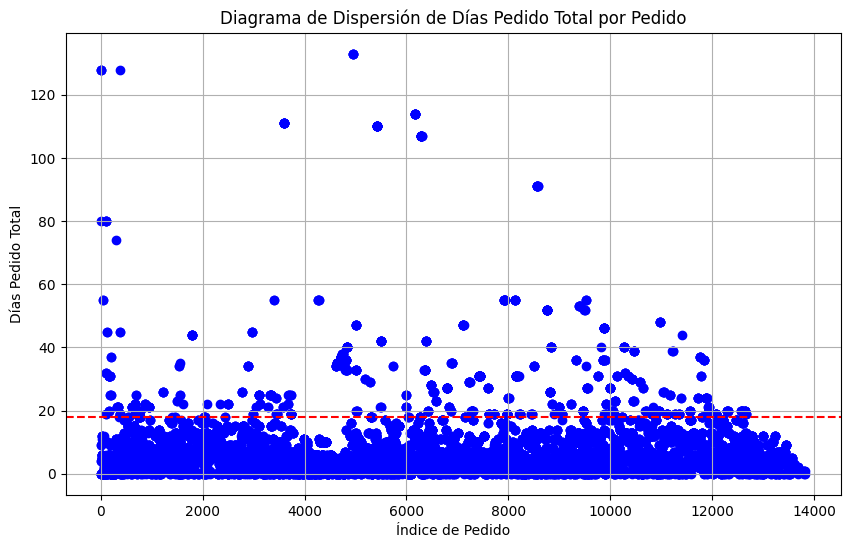

In [8]:
import matplotlib.pyplot as plt

# Crear un gráfico de dispersión con el índice en el eje X y los días totales del pedido en el eje Y
plt.figure(figsize=(10, 6))

# Graficar el índice vs. los días totales del pedido
plt.scatter(df.index, df['Dias Pedido Total'], color='blue')

# Agregar una línea horizontal en y = 18
plt.axhline(y=18, color='red', linestyle='--', label='Límite de 18 días')

# Agregar título y etiquetas de los ejes
plt.title('Diagrama de Dispersión de Días Pedido Total por Pedido')
plt.xlabel('Índice de Pedido')
plt.ylabel('Días Pedido Total')

# Mostrar el gráfico
plt.grid(True)
plt.show()

#### Veo cuantos pedidos duraron mas que 18 días y menos de 4 días

In [9]:
# Contar la cantidad total de pedidos únicos
cantidad_total_pedidos = df['Nº'].nunique()

# Contar la cantidad de pedidos que superan los 18 días de tardanza total
pedidos_mayor_18_dias = df[df['Dias Pedido Total'] > 18]['Nº'].nunique()

# Contar la cantidad de pedidos que están por debajo de los 4 días de tardanza total
pedidos_menor_4_dias = df[df['Dias Pedido Total'] < 4]['Nº'].nunique()

# Imprimir los resultados
print(f"Cantidad total de pedidos: {cantidad_total_pedidos}")
print(f"Cantidad de pedidos que superan los 18 días: {pedidos_mayor_18_dias}")
print(f"Cantidad de pedidos que están por debajo de 4 días: {pedidos_menor_4_dias}")

Cantidad total de pedidos: 2685
Cantidad de pedidos que superan los 18 días: 154
Cantidad de pedidos que están por debajo de 4 días: 1077


#### Grafico los días de vuelta y veo que hay muchos pedidos que tardan menos de un día y me doy cuenta que es porque se realizan tareas que duran 1 minuto

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


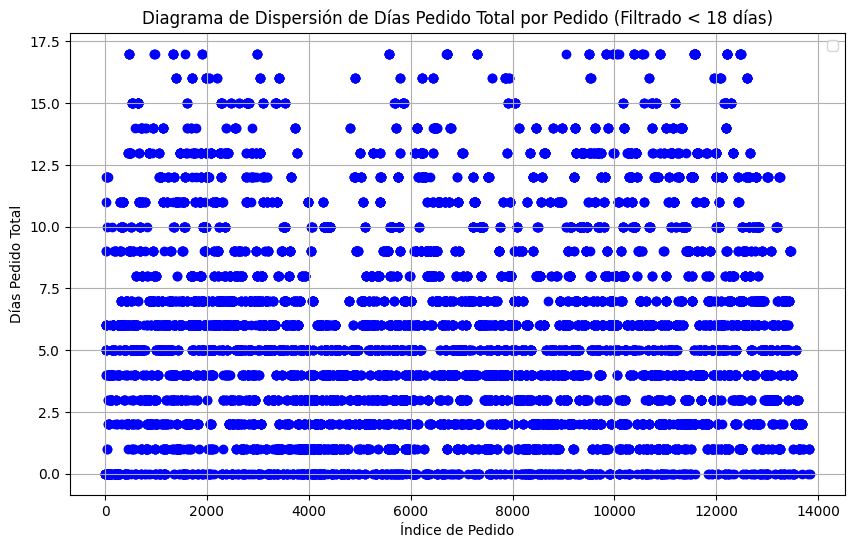

In [10]:
# Filtrar los pedidos que duran menos de 18 días
df_filtrado = df[df['Dias Pedido Total'] < 18]

# Crear un gráfico de dispersión con el índice en el eje X y los días totales del pedido en el eje Y (filtrado)
plt.figure(figsize=(10, 6))

# Graficar el índice vs. los días totales del pedido (filtrado)
plt.scatter(df_filtrado.index, df_filtrado['Dias Pedido Total'], color='blue')

# Agregar título y etiquetas de los ejes
plt.title('Diagrama de Dispersión de Días Pedido Total por Pedido (Filtrado < 18 días)')
plt.xlabel('Índice de Pedido')
plt.ylabel('Días Pedido Total')

# Agregar leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

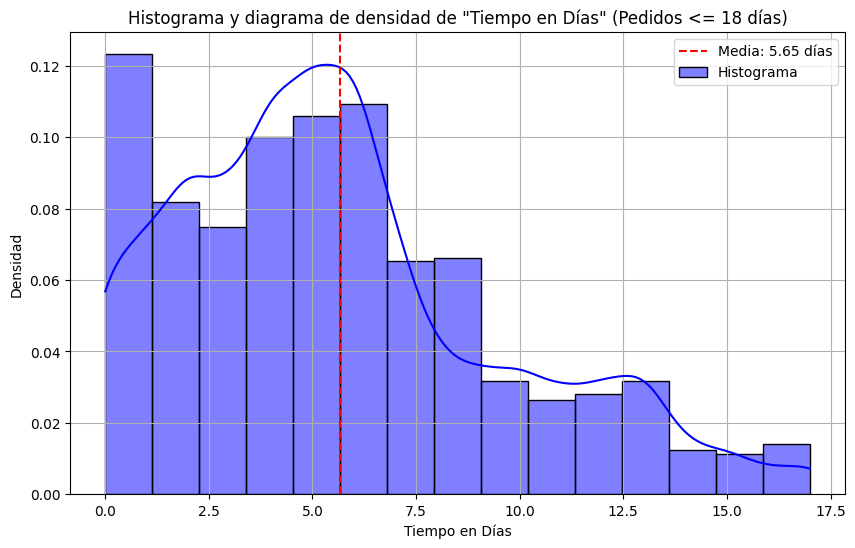

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Supongamos que 'df_filtrado' tiene la columna 'Dias Pedido Total' ya filtrada para <= 14 días
data = df_filtrado['Dias Pedido Total']

# Crear el histograma y la curva de densidad con un mayor número de bins
plt.figure(figsize=(10, 6))

# Ajustamos los bins a un número más alto (puedes ajustar este valor según la distribución)
sns.histplot(data, kde=True, color='blue', bins=15, stat="density", edgecolor='black', alpha=0.5, label='Histograma')

# Calcular la media
media = np.mean(data)

# Agregar una línea vertical para la media
plt.axvline(media, color='red', linestyle='--', label=f'Media: {media:.2f} días')

# Título y etiquetas
plt.title('Histograma y diagrama de densidad de "Tiempo en Días" (Pedidos <= 18 días)')
plt.xlabel('Tiempo en Días')
plt.ylabel('Densidad')

# Agregar leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()


#### Corrección de las etapas que duran 1 minuto

In [12]:
# Chequeamos la cantidad de registros que quedan en la base sin los que duran mas de 18 días totales

total_registros_df = len(df)
total_registros_df_filtrado = len(df_filtrado)

# Mostrar la diferencia
print(f"Total de registros en df: {total_registros_df}")
print(f"Total de registros en df_filtrado: {total_registros_df_filtrado}")
print(f"Diferencia de registros eliminados: {total_registros_df - total_registros_df_filtrado}")

Total de registros en df: 13226
Total de registros en df_filtrado: 12200
Diferencia de registros eliminados: 1026


In [13]:
# Contamos la cantidad de tareas que duran entre 0 a 3 minutos en hacerse

# Filtrar los registros que duran entre 0 y 3 minutos en la columna 'Minutos Tarea Neto'
registros_0_a_3_minutos = df_filtrado[(df_filtrado['Minutos Tarea Neto'] >= 0) & (df_filtrado['Minutos Tarea Neto'] <= 3)]

# Contar cuántos registros cumplen esta condición
cantidad_registros_0_a_3_minutos = len(registros_0_a_3_minutos)

# Imprimir el resultado
print(f"Cantidad de registros que duran entre 0 y 3 minutos: {cantidad_registros_0_a_3_minutos}")


Cantidad de registros que duran entre 0 y 3 minutos: 4771


In [14]:
# Calculamos los Minutos Tarea Neto promedio para cada Etapa

# Calcular el promedio de 'Minutos Tarea Neto' agrupado por 'Etapa'
promedio_minutos_por_etapa = df_filtrado.groupby('Etapa')['Minutos Tarea Neto'].mean().reset_index()

# Ordenar la lista de menor a mayor según el promedio
promedio_minutos_por_etapa = promedio_minutos_por_etapa.sort_values(by='Minutos Tarea Neto', ascending=True)

# Mostrar el resultado ordenado
print(promedio_minutos_por_etapa)

                     Etapa  Minutos Tarea Neto
27                  PULIDO            0.000000
8                CUBETILLA            0.000000
16                HIBRIDAS            0.500000
3                   ATACHE            3.000000
30                  RODETE           10.500000
33                 VACIADO           28.725806
12                   ENCIA           29.235294
24                 NUCLEOS           40.366667
6              CEMENTACIÓN           47.390361
23                 MONTAJE           60.640244
2   AJUSTE EN ESTADO VERDE           65.155280
25          PERNO DE FIBRA           74.714286
15                   GUIAS           76.934426
22                 MODELOS          121.969904
20                MAQUETAS          128.555556
29          RESINA HIBRIDA          137.242424
19                  LLAVES          155.102564
0                  ACABADO          173.463566
11              EMERGENTES          183.428571
34                ZIRCONIA          228.933985
26           

#### Reconoci que la etapa Cubetilla, Pulido e Hibridas duran 0 minutos

In [15]:
# Vemos cuantos pedidos tienen las siguientes etapas:

# Contar cuántas tareas hay para cada etapa: PULIDO, CUBETILLA, HIBRIDAS
etapas_interes = ['PULIDO', 'CUBETILLA', 'HIBRIDAS']

# Filtrar las tareas que pertenecen a las etapas de interés
tareas_interes = df_filtrado[df_filtrado['Etapa'].isin(etapas_interes)]

# Contar cuántas tareas hay para cada etapa
conteo_tareas_por_etapa = tareas_interes['Etapa'].value_counts()

# Mostrar el conteo de tareas por etapa
print("Cantidad de tareas por etapa:")
print(conteo_tareas_por_etapa)

# Contar cuántos pedidos únicos contienen alguna de estas etapas
cantidad_pedidos_con_etapas = tareas_interes['Nº'].nunique()

# Mostrar la cantidad de pedidos únicos
print(f"\nCantidad de pedidos que contienen alguna de estas etapas: {cantidad_pedidos_con_etapas}")


# Se proceden borrar los pedidos porque no suena real que una tarea dure tan poco en promedio, se consideran no consistentes.

# Filtrar los pedidos que NO contengan ninguna de estas etapas
df_filtrado = df_filtrado[~df_filtrado['Etapa'].isin(etapas_interes)]

# Mostrar el número de registros después de eliminar los pedidos con esas etapas
print(f"Cantidad de registros después de eliminar pedidos con etapas PULIDO, CUBETILLA, o HIBRIDAS: {len(df_filtrado)}")


Cantidad de tareas por etapa:
Etapa
PULIDO       2
HIBRIDAS     2
CUBETILLA    1
Name: count, dtype: int64

Cantidad de pedidos que contienen alguna de estas etapas: 4
Cantidad de registros después de eliminar pedidos con etapas PULIDO, CUBETILLA, o HIBRIDAS: 12195


#### Calculamos el promedio de Minutos Tarea Neto para cada Etapa ahora sin contar los que duran menos de 3 min

In [16]:
# Calculamos los Minutos Tarea Neto promedio para cada Etapa CALCULADO DE VUELTA PERO SIN LAS ETAPAS BORRADAS

# Filtrar los registros que tienen 'Minutos Tarea Neto' mayores a 3
df_filtrado_sin_0_a_3 = df_filtrado[df_filtrado['Minutos Tarea Neto'] > 3]

# Calcular el promedio de 'Minutos Tarea Neto' agrupado por 'Etapa' sin considerar los registros entre 0 y 3 minutos
promedio_minutos_por_etapa = df_filtrado_sin_0_a_3.groupby('Etapa')['Minutos Tarea Neto'].mean().reset_index()

# Ordenar la lista de menor a mayor según el promedio
promedio_minutos_por_etapa = promedio_minutos_por_etapa.sort_values(by='Minutos Tarea Neto', ascending=True)

# Mostrar el resultado ordenado
print(promedio_minutos_por_etapa)


                     Etapa  Minutos Tarea Neto
26                  RODETE           42.000000
22          PERNO DE FIBRA          130.500000
21                 NUCLEOS          134.555556
5              CEMENTACIÓN          143.408759
25          RESINA HIBRIDA          150.833333
2   AJUSTE EN ESTADO VERDE          200.083969
30                ZIRCONIA          235.250000
0                  ACABADO          239.539615
10                   ENCIA          248.333333
23                    PMMA          258.631868
13                   GUIAS          276.000000
8               DISILICATO          283.413793
17                MAQUETAS          288.500000
19                 MODELOS          293.841758
27                 SINTRON          306.000000
9               EMERGENTES          513.600000
15                 LEUCITA          522.000000
1                   AJUSTE          672.179850
12                GLASEADO          692.686275
18              MAQUILLAJE          702.665608
29           

#### Reemplazar los df_filtrados con registros < 3 minutos para que dure los mismo que el promedio de su etapa

In [17]:
# Aca pense que tenia todo vacio pero no
print(df_filtrado[['Início', 'Finalizado', 'Minutos Tarea Neto', "Horas Tarea Neto"]])

                   Início          Finalizado  Minutos Tarea Neto  \
4     2024-03-04 12:43:00 2024-03-04 12:43:00                 0.0   
5     2024-03-04 12:43:00 2024-03-04 12:43:00                 0.0   
6     2024-03-04 16:55:00 2024-03-04 16:55:00                 0.0   
7     2023-11-02 12:40:00 2023-11-02 12:41:00                 1.0   
8     2023-11-02 12:41:00 2023-11-02 12:41:00                 0.0   
...                   ...                 ...                 ...   
13813 2024-08-28 17:12:00 2024-08-30 16:02:00              1130.0   
13814 2024-08-30 14:16:00 2024-08-30 14:54:00                38.0   
13815 2024-08-29 11:36:00 2024-08-29 11:36:00                 0.0   
13816 2024-08-29 08:54:00 2024-08-30 08:16:00               562.0   
13834 2024-08-30 17:24:00 2024-08-30 17:25:00                 1.0   

      Horas Tarea Neto  
4                00:00  
5                00:00  
6                00:00  
7                00:01  
8                00:00  
...                ..

In [18]:
print(df_filtrado.head())

     Nº Repetición|Ajuste             Cliente  Ctd  \
4  0099                 -  SANTIAGO BRAVERMAN    6   
5  0099                 -  SANTIAGO BRAVERMAN    6   
6  0099                 -  SANTIAGO BRAVERMAN    6   
7  0163                 -      CARINA PACENZA    2   
8  0163                 -      CARINA PACENZA    2   

                     Servicio        Sector              Etapa  \
4         Diseño 3D por Pieza        DISEÑO  DISEÑO DE SONRISA   
5         Diseño 3D por Pieza  IMPRESION 3D            ACABADO   
6         Diseño 3D por Pieza  IMPRESION 3D            MODELOS   
7  Incrustación de Disilicato      CERAMICA         MAQUILLAJE   
8  Incrustación de Disilicato      CERAMICA           GLASEADO   

                  Empleado              Início          Finalizado  \
4          LUCAS RODRIGUEZ 2024-03-04 12:43:00 2024-03-04 12:43:00   
5          LUCAS RODRIGUEZ 2024-03-04 12:43:00 2024-03-04 12:43:00   
6             MARIA CAMPOS 2024-03-04 16:55:00 2024-03-04 16:55:00  

In [19]:
import numpy as np

# Función para generar un número aleatorio dentro del rango del ±30% del promedio
def generar_valor_aleatorio(promedio):
    rango_min = promedio * 0.7
    rango_max = promedio * 1.3
    return np.random.uniform(rango_min, rango_max)

# Reemplazar los valores entre 0 y 3 en 'Minutos Tarea Neto' según su 'Etapa'
for index, row in df_filtrado.iterrows():
    if 0 <= row['Minutos Tarea Neto'] <= 3:
        # Obtener el promedio de la Etapa correspondiente desde la tabla de promedios
        promedio_etapa = promedio_minutos_por_etapa.loc[promedio_minutos_por_etapa['Etapa'] == row['Etapa'], 'Minutos Tarea Neto'].values
        if len(promedio_etapa) > 0:
            promedio = promedio_etapa[0]
            # Generar un nuevo valor ±30% alrededor del promedio
            nuevo_valor = generar_valor_aleatorio(promedio)
            # Asignar el nuevo valor a 'Minutos Tarea Neto'
            df_filtrado.at[index, 'Minutos Tarea Neto'] = nuevo_valor
            
            # Calcular y actualizar "Horas Tarea Neto" y "Días Tarea Neto" en función del nuevo valor
            horas_tarea_neto = nuevo_valor / 60  # Convertir minutos a horas
            dias_tarea_neto = nuevo_valor / 1440  # Convertir minutos a días
            
            # Actualizar las columnas calculadas
            df_filtrado.at[index, 'Horas Tarea Neto'] = f"{int(horas_tarea_neto):02d}:{int((horas_tarea_neto - int(horas_tarea_neto)) * 60):02d}"
            df_filtrado.at[index, 'Días Tarea Neto'] = dias_tarea_neto

# Recalcular los campos de "Minutos Pedido Neto", "Horas Pedido Neto" y "Días Pedido Neto" para cada pedido
for pedido in df_filtrado['Nº'].unique():
    # Filtrar las filas correspondientes al pedido actual
    pedido_filtro = df_filtrado[df_filtrado['Nº'] == pedido]
    
    # Sumar los valores de "Minutos Tarea Neto" para este pedido
    total_minutos_pedido = pedido_filtro['Minutos Tarea Neto'].sum()
    
    # Calcular las horas y días correspondientes
    total_horas_pedido = total_minutos_pedido / 60
    total_dias_pedido = total_minutos_pedido / 1440
    
    # Asignar los valores calculados a todas las filas del pedido actual
    df_filtrado.loc[df_filtrado['Nº'] == pedido, 'Minutos Pedido Neto'] = total_minutos_pedido
    df_filtrado.loc[df_filtrado['Nº'] == pedido, 'Horas Pedido Neto'] = f"{int(total_horas_pedido):02d}:{int((total_horas_pedido - int(total_horas_pedido)) * 60):02d}"
    df_filtrado.loc[df_filtrado['Nº'] == pedido, 'Días Pedido Neto'] = total_dias_pedido

# Imprimir la tabla actualizada
print(df_filtrado.head())


     Nº Repetición|Ajuste             Cliente  Ctd  \
4  0099                 -  SANTIAGO BRAVERMAN    6   
5  0099                 -  SANTIAGO BRAVERMAN    6   
6  0099                 -  SANTIAGO BRAVERMAN    6   
7  0163                 -      CARINA PACENZA    2   
8  0163                 -      CARINA PACENZA    2   

                     Servicio        Sector              Etapa  \
4         Diseño 3D por Pieza        DISEÑO  DISEÑO DE SONRISA   
5         Diseño 3D por Pieza  IMPRESION 3D            ACABADO   
6         Diseño 3D por Pieza  IMPRESION 3D            MODELOS   
7  Incrustación de Disilicato      CERAMICA         MAQUILLAJE   
8  Incrustación de Disilicato      CERAMICA           GLASEADO   

                  Empleado              Início          Finalizado  \
4          LUCAS RODRIGUEZ 2024-03-04 12:43:00 2024-03-04 12:43:00   
5          LUCAS RODRIGUEZ 2024-03-04 12:43:00 2024-03-04 12:43:00   
6             MARIA CAMPOS 2024-03-04 16:55:00 2024-03-04 16:55:00  

#### Cambiar la fecha finalizacion teniendo en cuenta los horarios y dias laborales

In [20]:
import pandas as pd
from datetime import datetime, timedelta

# Definir el rango laboral (de lunes a viernes, de 08:00 a 18:00)
hora_inicio_laboral = timedelta(hours=8)
hora_fin_laboral = timedelta(hours=18)
minutos_por_dia_laboral = (hora_fin_laboral - hora_inicio_laboral).total_seconds() / 60  # 600 minutos laborales por día

# Función para redondear a minutos completos
def redondear_a_minutos_completos(fecha):
    return fecha.replace(second=0, microsecond=0)

# Función para sumar minutos y calcular la nueva fecha de finalización
def calcular_fecha_finalizacion(inicio, minutos_tarea):
    # Convertir el inicio a datetime si es necesario
    if isinstance(inicio, str):
        inicio = pd.to_datetime(inicio)
    
    # Redondear la fecha de inicio a minutos completos
    inicio = redondear_a_minutos_completos(inicio)
    
    # Calcular el número de minutos que restan para finalizar el día laboral del inicio
    minutos_restantes_dia = max(0, (hora_fin_laboral - (inicio - inicio.replace(hour=0, minute=0, second=0, microsecond=0))).total_seconds() / 60)
    
    # Si los minutos de la tarea caben en el día laboral restante
    if minutos_tarea <= minutos_restantes_dia:
        finalizacion = inicio + timedelta(minutes=minutos_tarea)
        return redondear_a_minutos_completos(finalizacion)
    
    # Si los minutos de tarea exceden el tiempo disponible hoy, calcular los días adicionales
    minutos_tarea -= minutos_restantes_dia
    finalizacion = inicio + timedelta(minutes=minutos_restantes_dia)
    
    # Avanzar al próximo día laboral
    while minutos_tarea > 0:
        finalizacion += timedelta(days=1)
        
        # Si es fin de semana, avanzar hasta el lunes
        while finalizacion.weekday() >= 5:  # Sábado=5, Domingo=6
            finalizacion += timedelta(days=1)
        
        # Calcular cuántos minutos trabajar ese día
        minutos_a_trabajar = min(minutos_tarea, minutos_por_dia_laboral)
        finalizacion = finalizacion.replace(hour=8, minute=0, second=0, microsecond=0) + timedelta(minutes=minutos_a_trabajar)
        minutos_tarea -= minutos_a_trabajar
    
    return redondear_a_minutos_completos(finalizacion)

# Aplicar la función para recalcular la columna "Finalizado" y redondear a minutos completos
df_filtrado['Finalizado'] = df_filtrado.apply(lambda row: calcular_fecha_finalizacion(row['Início'], row['Minutos Tarea Neto']), axis=1)

# Imprimir la tabla con las fechas de finalización recalculadas y redondeadas
print(df_filtrado.head())


     Nº Repetición|Ajuste             Cliente  Ctd  \
4  0099                 -  SANTIAGO BRAVERMAN    6   
5  0099                 -  SANTIAGO BRAVERMAN    6   
6  0099                 -  SANTIAGO BRAVERMAN    6   
7  0163                 -      CARINA PACENZA    2   
8  0163                 -      CARINA PACENZA    2   

                     Servicio        Sector              Etapa  \
4         Diseño 3D por Pieza        DISEÑO  DISEÑO DE SONRISA   
5         Diseño 3D por Pieza  IMPRESION 3D            ACABADO   
6         Diseño 3D por Pieza  IMPRESION 3D            MODELOS   
7  Incrustación de Disilicato      CERAMICA         MAQUILLAJE   
8  Incrustación de Disilicato      CERAMICA           GLASEADO   

                  Empleado              Início          Finalizado  \
4          LUCAS RODRIGUEZ 2024-03-04 12:43:00 2024-03-06 17:15:00   
5          LUCAS RODRIGUEZ 2024-03-04 12:43:00 2024-03-04 16:01:00   
6             MARIA CAMPOS 2024-03-04 16:55:00 2024-03-05 11:50:00  

#### Cambiar la cantidad de Dias Pedido Total

In [21]:
import pandas as pd

# Función para calcular los días totales entre la primera fecha de inicio y la última fecha de finalización de cada pedido
def calcular_dias_pedido_total(df):
    # Agrupar por 'Nº Repetición' para cada pedido
    for pedido in df['Nº'].unique():
        # Filtrar el DataFrame para obtener las filas correspondientes a este pedido
        pedido_filtro = df[df['Nº'] == pedido]
        
        # Obtener la primera fecha de inicio (mínima)
        fecha_inicio = pd.to_datetime(pedido_filtro['Início']).min()
        
        # Obtener la última fecha de finalización (máxima)
        fecha_finalizacion = pd.to_datetime(pedido_filtro['Finalizado']).max()
        
        # Calcular la diferencia en días entre la fecha de inicio y la fecha de finalización
        dias_pedido_total = (fecha_finalizacion - fecha_inicio).days
        
        # Asignar este valor a todas las filas de ese pedido en la columna 'Dias Pedido Total'
        df.loc[df['Nº'] == pedido, 'Dias Pedido Total'] = dias_pedido_total

# Aplicar la función al DataFrame
calcular_dias_pedido_total(df_filtrado)

# Imprimir la tabla con la columna 'Dias Pedido Total' calculada
print(df_filtrado.head())


     Nº Repetición|Ajuste             Cliente  Ctd  \
4  0099                 -  SANTIAGO BRAVERMAN    6   
5  0099                 -  SANTIAGO BRAVERMAN    6   
6  0099                 -  SANTIAGO BRAVERMAN    6   
7  0163                 -      CARINA PACENZA    2   
8  0163                 -      CARINA PACENZA    2   

                     Servicio        Sector              Etapa  \
4         Diseño 3D por Pieza        DISEÑO  DISEÑO DE SONRISA   
5         Diseño 3D por Pieza  IMPRESION 3D            ACABADO   
6         Diseño 3D por Pieza  IMPRESION 3D            MODELOS   
7  Incrustación de Disilicato      CERAMICA         MAQUILLAJE   
8  Incrustación de Disilicato      CERAMICA           GLASEADO   

                  Empleado              Início          Finalizado  \
4          LUCAS RODRIGUEZ 2024-03-04 12:43:00 2024-03-06 17:15:00   
5          LUCAS RODRIGUEZ 2024-03-04 12:43:00 2024-03-04 16:01:00   
6             MARIA CAMPOS 2024-03-04 16:55:00 2024-03-05 11:50:00  

#### Ahora que corregimos las tareas con 1 minuto probamos ver al distribución de vuelta

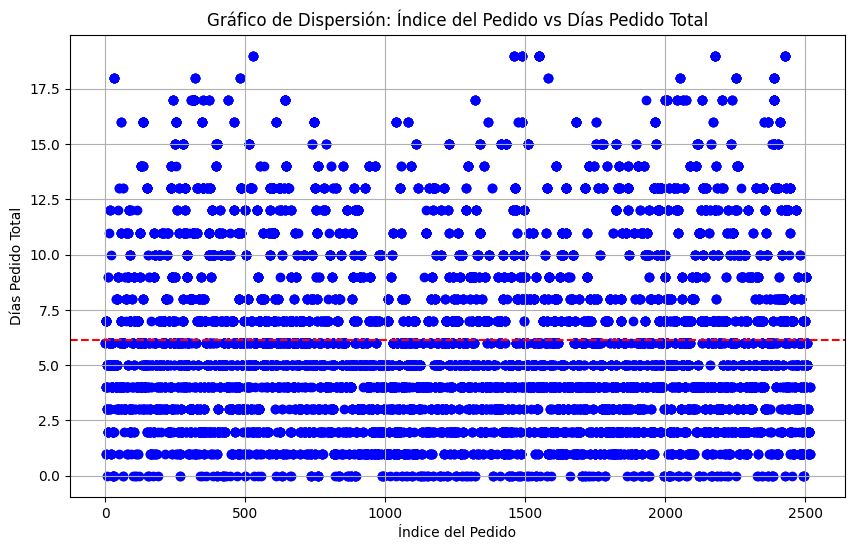

In [22]:
import matplotlib.pyplot as plt

# Asegúrate de que 'df_filtrado' sea tu DataFrame
# Crear una nueva columna para el índice del pedido
df_filtrado['Indice Pedido'] = df_filtrado['Nº'].astype('category').cat.codes

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df_filtrado['Indice Pedido'], df_filtrado['Dias Pedido Total'], color='blue')

# Calcular la media de 'Días Pedido Total'
media_dias_pedido = df_filtrado['Dias Pedido Total'].mean()

# Agregar una línea horizontal en la media
plt.axhline(y=media_dias_pedido, color='red', linestyle='--', label=f'Media: {media_dias_pedido:.2f}')

# Agregar títulos y etiquetas
plt.title('Gráfico de Dispersión: Índice del Pedido vs Días Pedido Total')
plt.xlabel('Índice del Pedido')
plt.ylabel('Días Pedido Total')

# Mostrar el gráfico
plt.grid(True)
plt.show()


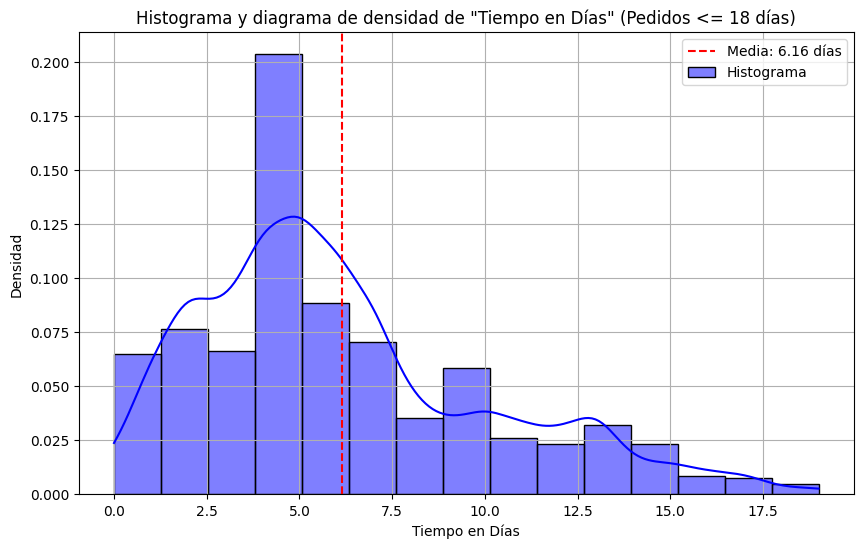

In [23]:
# Supongamos que 'df_filtrado' tiene la columna 'Dias Pedido Total' ya filtrada para <= 14 días
data2 = df_filtrado['Dias Pedido Total']

# Crear el histograma y la curva de densidad con un mayor número de bins
plt.figure(figsize=(10, 6))

# Ajustamos los bins a un número más alto (puedes ajustar este valor según la distribución)
sns.histplot(data2, kde=True, color='blue', bins=15, stat="density", edgecolor='black', alpha=0.5, label='Histograma')

# Calcular la media
media = np.mean(data2)

# Agregar una línea vertical para la media
plt.axvline(media, color='red', linestyle='--', label=f'Media: {media:.2f} días')

# Título y etiquetas
plt.title('Histograma y diagrama de densidad de "Tiempo en Días" (Pedidos <= 18 días)')
plt.xlabel('Tiempo en Días')
plt.ylabel('Densidad')

# Agregar leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()


#### Chaqueo NAs

In [24]:
na_por_columna = df_filtrado.isnull().sum()

# Mostramos el resultado
print(na_por_columna)

Nº                     0
Repetición|Ajuste      0
Cliente                0
Ctd                    0
Servicio               0
Sector                 0
Etapa                  0
Empleado               0
Início                 0
Finalizado             0
Fecha entrada          0
Fecha prevista         0
Horas Tarea Neto       0
Minutos Tarea Neto     0
Días Tarea Neto        0
Horas Pedido Neto      0
Minutos Pedido Neto    0
Días Pedido Neto       0
Dias Pedido Total      0
Indice Pedido          0
dtype: int64


#### Chequeamos variable Ctd 

In [25]:
df_filtrado["Ctd"].describe()

count    12195.000000
mean         3.236490
std          4.001701
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         46.000000
Name: Ctd, dtype: float64

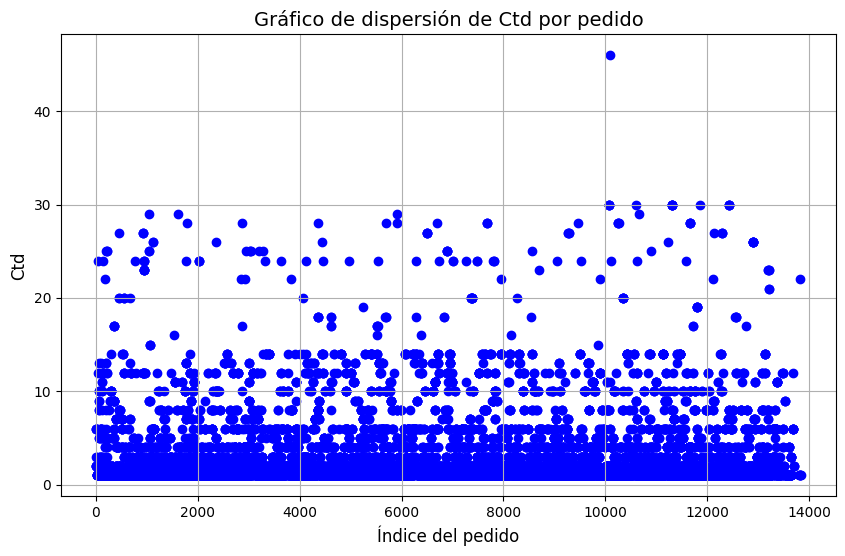

In [26]:
import matplotlib.pyplot as plt

# Creamos el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df_filtrado.index, df_filtrado["Ctd"], color='blue')

# Añadimos etiquetas y título
plt.title("Gráfico de dispersión de Ctd por pedido", fontsize=14)
plt.xlabel("Índice del pedido", fontsize=12)
plt.ylabel("Ctd", fontsize=12)

# Mostramos el gráfico
plt.grid(True)
plt.show()

In [27]:
df_filtrado[df_filtrado["Ctd"] == 46]


,Nº,Repetición|Ajuste,Cliente,Ctd,Servicio,Sector,Etapa,Empleado,Início,Finalizado,Fecha entrada,Fecha prevista,Horas Tarea Neto,Minutos Tarea Neto,Días Tarea Neto,Horas Pedido Neto,Minutos Pedido Neto,Días Pedido Neto,Dias Pedido Total,Indice Pedido
10082,1624,-,MARTIN FERNUNSON,46,Diseño 3D por Pieza,DISEÑO,DISEÑO DE SONRISA,DEMIAN SANTOS,2024-06-07 10:19:00,2024-06-10 14:11:00,07/06/2024 09:12,19/06/2024,13:52,832.0,0.577778,13:52,832.0,0.577778,3.0,2090


In [28]:
# Eliminamos los registros donde "Ctd" es igual a 46
df_filtrado = df_filtrado[df_filtrado["Ctd"] != 46]

#### Anonimizamos los clientes

In [29]:
# Creamos un diccionario para mapear los clientes reales a un número ascendente
clientes_unicos = df_filtrado["Cliente"].unique()
mapa_clientes = {cliente: idx + 1 for idx, cliente in enumerate(clientes_unicos)}

# Creamos una nueva tabla con el ID del cliente y su nombre real
tabla_clientes = pd.DataFrame(list(mapa_clientes.items()), columns=["ID Cliente", "Nombre Real"])

# Reemplazamos los nombres de los clientes por su ID en la columna "Cliente"
df_filtrado["Cliente"] = df_filtrado["Cliente"].map(mapa_clientes)

# Mostramos la nueva tabla de clientes y la tabla df con la columna "Cliente" anonimizada
print(tabla_clientes)
print(df_filtrado.head())

                  ID Cliente  Nombre Real
0         SANTIAGO BRAVERMAN            1
1             CARINA PACENZA            2
2           NORBERTO FUERTES            3
3     HECTOR ALVAREZ CANTONI            4
4      FRANCISCO JAVIER LELL            5
..                       ...          ...
128  MARIA ANTONELLA PISSACO          129
129           PEDRO GAZZOTTI          130
130     JUAN FRANCISCO YUNEZ          131
131               SOL ARAUJO          132
132              NORA HARFIN          133

[133 rows x 2 columns]
     Nº Repetición|Ajuste  Cliente  Ctd                    Servicio  \
4  0099                 -        1    6         Diseño 3D por Pieza   
5  0099                 -        1    6         Diseño 3D por Pieza   
6  0099                 -        1    6         Diseño 3D por Pieza   
7  0163                 -        2    2  Incrustación de Disilicato   
8  0163                 -        2    2  Incrustación de Disilicato   

         Sector              Etapa           

#### Anonimizamos los Empleados

In [30]:
# Creamos un diccionario para mapear los empleados reales a un número ascendente
empleados_unicos = df_filtrado["Empleado"].unique()
mapa_empleados = {empleado: idx + 1 for idx, empleado in enumerate(empleados_unicos)}

# Creamos una nueva tabla con el ID del empleado y su nombre real
tabla_empleados = pd.DataFrame(list(mapa_empleados.items()), columns=["ID Empleado", "Nombre Real"])

# Reemplazamos los nombres de los empleados por su ID en la columna "Empleado"
df_filtrado["Empleado"] = df_filtrado["Empleado"].map(mapa_empleados)

# Mostramos la nueva tabla de empleados y la tabla df con la columna "Empleado" anonimizada
print(tabla_empleados)
print(df_filtrado.head())

               ID Empleado  Nombre Real
0          LUCAS RODRIGUEZ            1
1             MARIA CAMPOS            2
2  VIRGINIA PIERUCCI GECHT            3
3             NORMA JUNCAL            4
4          LUCIANO TORIANI            5
5      JUAN MANUEL CORDOBA            6
6            PABLO SCHÄFER            7
7          RICARDO SCHÄFER            8
8            DEMIAN SANTOS            9
9            CRISTINA CRIS           10
     Nº Repetición|Ajuste  Cliente  Ctd                    Servicio  \
4  0099                 -        1    6         Diseño 3D por Pieza   
5  0099                 -        1    6         Diseño 3D por Pieza   
6  0099                 -        1    6         Diseño 3D por Pieza   
7  0163                 -        2    2  Incrustación de Disilicato   
8  0163                 -        2    2  Incrustación de Disilicato   

         Sector              Etapa  Empleado              Início  \
4        DISEÑO  DISEÑO DE SONRISA         1 2024-03-04 12:43:00 

#### Agrego ATRASADO y cuantos días

In [31]:
# Agrego ATRASADO (SI o NO)

# Convertir las columnas de fechas a tipo datetime para poder comparar, especificando dayfirst=True
df_filtrado['Finalizado'] = pd.to_datetime(df_filtrado['Finalizado'])
df_filtrado['Fecha prevista'] = pd.to_datetime(df_filtrado['Fecha prevista'], dayfirst=True)

# Agrupar por ID Pedido y obtener la última fecha de finalización por pedido
df_filtrado['Última Finalización'] = df_filtrado.groupby('Nº')['Finalizado'].transform('max')

# Comparar la última fecha de finalización con la fecha prevista para determinar si el pedido está atrasado
df_filtrado['Atrasado'] = df_filtrado['Última Finalización'] > df_filtrado['Fecha prevista']

# Convertir el booleano True/False a 'SI' o 'NO'
df_filtrado['Atrasado'] = df_filtrado['Atrasado'].apply(lambda x: 'SI' if x else 'NO')

# Mostrar el DataFrame resultante
print(df_filtrado)

           Nº Repetición|Ajuste  Cliente  Ctd                       Servicio  \
4        0099                 -        1    6            Diseño 3D por Pieza   
5        0099                 -        1    6            Diseño 3D por Pieza   
6        0099                 -        1    6            Diseño 3D por Pieza   
7        0163                 -        2    2     Incrustación de Disilicato   
8        0163                 -        2    2     Incrustación de Disilicato   
...       ...               ...      ...  ...                            ...   
13813  1858-2                 A       12   22            Diseño 3D por Pieza   
13814    2036                 -        4    1            Diseño 3D por Pieza   
13815    2036                 -        4    1            Diseño 3D por Pieza   
13816    2036                 -        4    1            Diseño 3D por Pieza   
13834  1766-3                 A        9    1  Corona de Zirconia Monolitica   

             Sector              Etapa 

In [32]:
# Agrego Dias de Atraso
# 
#  Convertir las columnas de fechas a tipo datetime para poder comparar, especificando dayfirst=True
df_filtrado['Finalizado'] = pd.to_datetime(df_filtrado['Finalizado'])
df_filtrado['Fecha prevista'] = pd.to_datetime(df_filtrado['Fecha prevista'], dayfirst=True)

# Agrupar por ID Pedido y obtener la última fecha de finalización por pedido
df_filtrado['Última Finalización'] = df_filtrado.groupby('Nº')['Finalizado'].transform('max')

# Comparar la última fecha de finalización con la fecha prevista para determinar si el pedido está atrasado
df_filtrado['Atrasado'] = df_filtrado['Última Finalización'] > df_filtrado['Fecha prevista']

# Calcular los días de atraso, solo si el pedido está atrasado, y agregarlo en una nueva columna
df_filtrado['Días de Atraso'] = (df_filtrado['Última Finalización'] - df_filtrado['Fecha prevista']).dt.days
df_filtrado['Días de Atraso'] = df_filtrado['Días de Atraso'].apply(lambda x: x if x > 0 else 0)

# Convertir el booleano True/False a 'SI' o 'NO' en la columna Atrasado
df_filtrado['Atrasado'] = df_filtrado['Atrasado'].apply(lambda x: 'SI' if x else 'NO')

# Mostrar el DataFrame resultante
print(df_filtrado.head())

     Nº Repetición|Ajuste  Cliente  Ctd                    Servicio  \
4  0099                 -        1    6         Diseño 3D por Pieza   
5  0099                 -        1    6         Diseño 3D por Pieza   
6  0099                 -        1    6         Diseño 3D por Pieza   
7  0163                 -        2    2  Incrustación de Disilicato   
8  0163                 -        2    2  Incrustación de Disilicato   

         Sector              Etapa  Empleado              Início  \
4        DISEÑO  DISEÑO DE SONRISA         1 2024-03-04 12:43:00   
5  IMPRESION 3D            ACABADO         1 2024-03-04 12:43:00   
6  IMPRESION 3D            MODELOS         2 2024-03-04 16:55:00   
7      CERAMICA         MAQUILLAJE         3 2023-11-02 12:40:00   
8      CERAMICA           GLASEADO         3 2023-11-02 12:41:00   

           Finalizado  ... Minutos Tarea Neto Días Tarea Neto  \
4 2024-03-06 17:15:00  ...        1472.502713        1.022571   
5 2024-03-04 16:01:00  ...        

#### Chequeamos lo de los horarios laborales

In [33]:
import pandas as pd

# Definir las horas laborales
hora_inicio_laboral = 8
hora_fin_laboral = 18

# Función para verificar si una fecha está fuera del horario laboral
def fuera_horario_laboral(fecha):
    # Asegurarse de que 'fecha' sea de tipo datetime
    fecha = pd.to_datetime(fecha)
    
    # Verificar si está fuera del horario laboral o si es fin de semana
    es_fin_de_semana = fecha.weekday() >= 5  # Sábado = 5, Domingo = 6
    fuera_horas_laborales = fecha.hour < hora_inicio_laboral or fecha.hour >= hora_fin_laboral
    
    return es_fin_de_semana or fuera_horas_laborales

# Aplicar la función para contar las veces que 'Finalizado' está fuera del horario laboral
fechas_fuera_horario = df_filtrado['Finalizado'].apply(fuera_horario_laboral)

# Contar cuántas fechas están fuera del horario laboral
cantidad_fuera_horario = fechas_fuera_horario.sum()

# Imprimir el resultado
print(f"Cantidad de veces que la fecha de finalización está fuera del horario laboral: {cantidad_fuera_horario}")

registros_fuera_horario = df_filtrado[df_filtrado['Finalizado'].apply(fuera_horario_laboral)]

# Mostrar los registros
print(registros_fuera_horario)


Cantidad de veces que la fecha de finalización está fuera del horario laboral: 267
           Nº Repetición|Ajuste  Cliente  Ctd  \
41       0074                 -       12   12   
47       0088                 -       12   24   
140      0111                 -        9   12   
149      0033                 -       31    2   
150      0033                 -       31    2   
...       ...               ...      ...  ...   
13197  1062-2                 -       46    1   
13321    2000                 -       70    2   
13359    2003                 -       42    1   
13409    2008                 -       56    1   
13567    2016                 -       56    1   

                               Servicio        Sector              Etapa  \
41                  Diseño 3D por Pieza        DISEÑO  DISEÑO DE SONRISA   
47                  Diseño 3D por Pieza        DISEÑO  DISEÑO DE SONRISA   
140    Carilla de Disilicato Monolítica       FRESADO             AJUSTE   
149     Corona de Disili

#### Chequeamos valores negativos en los campos calculados

In [34]:
# Verificar cuántos registros en 'Minutos Tarea Neto' son negativos
registros_negativos = df_filtrado[df_filtrado['Minutos Tarea Neto'] < 0]

# Contar la cantidad de registros negativos
cantidad_registros_negativos = registros_negativos.shape[0]

# Mostrar la cantidad de registros negativos
print(f"Cantidad de registros con 'Minutos Tarea Neto' negativos: {cantidad_registros_negativos}")

# Si deseas ver los registros negativos:
print(registros_negativos)

# Identificar los pedidos que tienen algún registro con 'Minutos Tarea Neto' negativo
pedidos_con_negativos = df_filtrado[df_filtrado['Minutos Tarea Neto'] < 0]['Nº'].unique()

# Eliminar todos los registros correspondientes a esos pedidos
df_filtrado_sin_negativos = df_filtrado[~df_filtrado['Nº'].isin(pedidos_con_negativos)]

# Mostrar la cantidad de registros eliminados
registros_eliminados = df_filtrado.shape[0] - df_filtrado_sin_negativos.shape[0]
print(f"Cantidad de registros eliminados: {registros_eliminados}")

# Actualizar el DataFrame original 
df_filtrado = df_filtrado_sin_negativos

Cantidad de registros con 'Minutos Tarea Neto' negativos: 3
         Nº Repetición|Ajuste  Cliente  Ctd                       Servicio  \
1938   0535                 -       64    3  Corona de Zirconia Monolitica   
12017  1851                 -       55    1  Corona de Zirconia Monolitica   
13321  2000                 -       70    2       Digitalización de Modelo   

        Sector    Etapa  Empleado              Início          Finalizado  \
1938    DISEÑO  CORONAS         4 2023-12-04 07:43:00 2023-12-04 07:38:00   
12017  FRESADO   AJUSTE         7 2024-07-30 07:28:00 2024-07-30 07:18:00   
13321   DISEÑO  MODELOS         9 2024-08-22 07:53:00 2024-08-22 07:47:00   

       ... Minutos Tarea Neto Días Tarea Neto Horas Pedido Neto  \
1938   ...               -5.0       -0.003472             52:41   
12017  ...              -10.0       -0.006944             20:07   
13321  ...               -6.0       -0.004167             05:11   

       Minutos Pedido Neto  Días Pedido Neto Dias

#### Agregar Nombre dia de semana

In [35]:
import pandas as pd

# Asegúrate de que las columnas 'Início' y 'Finalizado' sean de tipo datetime
df_filtrado['Início'] = pd.to_datetime(df_filtrado['Início'])
df_filtrado['Finalizado'] = pd.to_datetime(df_filtrado['Finalizado'])

# Crear las columnas con el nombre del día de la semana
df_filtrado['Día Semana Inicio'] = df_filtrado['Início'].dt.day_name()
df_filtrado['Día Semana Finalización'] = df_filtrado['Finalizado'].dt.day_name()

print(df_filtrado.head())

     Nº Repetición|Ajuste  Cliente  Ctd                    Servicio  \
4  0099                 -        1    6         Diseño 3D por Pieza   
5  0099                 -        1    6         Diseño 3D por Pieza   
6  0099                 -        1    6         Diseño 3D por Pieza   
7  0163                 -        2    2  Incrustación de Disilicato   
8  0163                 -        2    2  Incrustación de Disilicato   

         Sector              Etapa  Empleado              Início  \
4        DISEÑO  DISEÑO DE SONRISA         1 2024-03-04 12:43:00   
5  IMPRESION 3D            ACABADO         1 2024-03-04 12:43:00   
6  IMPRESION 3D            MODELOS         2 2024-03-04 16:55:00   
7      CERAMICA         MAQUILLAJE         3 2023-11-02 12:40:00   
8      CERAMICA           GLASEADO         3 2023-11-02 12:41:00   

           Finalizado  ... Horas Pedido Neto Minutos Pedido Neto  \
4 2024-03-06 17:15:00  ...             32:45         1965.704135   
5 2024-03-04 16:01:00  ...  

#### Filtrar los días < 18

In [36]:
df_filtrado = df_filtrado[df_filtrado['Dias Pedido Total'] < 18]

# Contar el número total de registros en el DataFrame
cantidad_registros = df_filtrado.shape[0]

# Mostrar la cantidad de registros
print(f"Cantidad total de registros: {cantidad_registros}")

Cantidad total de registros: 12104


In [37]:
# Eliminar la columna 'Indice Pedido' si existe en el DataFrame
if 'Indice Pedido' in df_filtrado.columns:
    df_filtrado = df_filtrado.drop(columns=['Indice Pedido'])

# Mostrar el DataFrame sin la columna 'Indice Pedido'
print(df_filtrado.head())

     Nº Repetición|Ajuste  Cliente  Ctd                    Servicio  \
4  0099                 -        1    6         Diseño 3D por Pieza   
5  0099                 -        1    6         Diseño 3D por Pieza   
6  0099                 -        1    6         Diseño 3D por Pieza   
7  0163                 -        2    2  Incrustación de Disilicato   
8  0163                 -        2    2  Incrustación de Disilicato   

         Sector              Etapa  Empleado              Início  \
4        DISEÑO  DISEÑO DE SONRISA         1 2024-03-04 12:43:00   
5  IMPRESION 3D            ACABADO         1 2024-03-04 12:43:00   
6  IMPRESION 3D            MODELOS         2 2024-03-04 16:55:00   
7      CERAMICA         MAQUILLAJE         3 2023-11-02 12:40:00   
8      CERAMICA           GLASEADO         3 2023-11-02 12:41:00   

           Finalizado  ... Días Tarea Neto Horas Pedido Neto  \
4 2024-03-06 17:15:00  ...        1.022571             32:45   
5 2024-03-04 16:01:00  ...        0.

#### Agregar columnas calculadas Abril

In [38]:
# Promedio de horas por sector

# Función para convertir el formato 'hh:mm' a horas decimales
def convertir_a_horas_decimales(tiempo):
    horas, minutos = map(int, tiempo.split(':'))
    return horas + minutos / 60

# Aplicar la conversión a la columna 'horas'
df_filtrado['horas_decimales'] = df_filtrado['Horas Pedido Neto'].apply(convertir_a_horas_decimales)

# Calcular el promedio de horas por sector
df_filtrado['promedio_horas_sector'] = df_filtrado.groupby('Sector')['horas_decimales'].transform('mean')

In [39]:
# Promedio de horas por sector y servicio

# Función para convertir el formato 'hh:mm' a horas decimales
def convertir_a_horas_decimales(tiempo):
    horas, minutos = map(int, tiempo.split(':'))
    return horas + minutos / 60

# Aplicar la conversión a la columna 'horas'
df_filtrado['horas_decimales'] = df_filtrado['Horas Pedido Neto'].apply(convertir_a_horas_decimales)

# Calcular el promedio de horas por sector y servicio
df_filtrado['promedio_horas_sector_servicio'] = df_filtrado.groupby(['Sector', 'Servicio'])['horas_decimales'].transform('mean')

print(df_filtrado.head())

     Nº Repetición|Ajuste  Cliente  Ctd                    Servicio  \
4  0099                 -        1    6         Diseño 3D por Pieza   
5  0099                 -        1    6         Diseño 3D por Pieza   
6  0099                 -        1    6         Diseño 3D por Pieza   
7  0163                 -        2    2  Incrustación de Disilicato   
8  0163                 -        2    2  Incrustación de Disilicato   

         Sector              Etapa  Empleado              Início  \
4        DISEÑO  DISEÑO DE SONRISA         1 2024-03-04 12:43:00   
5  IMPRESION 3D            ACABADO         1 2024-03-04 12:43:00   
6  IMPRESION 3D            MODELOS         2 2024-03-04 16:55:00   
7      CERAMICA         MAQUILLAJE         3 2023-11-02 12:40:00   
8      CERAMICA           GLASEADO         3 2023-11-02 12:41:00   

           Finalizado  ... Días Pedido Neto Dias Pedido Total  \
4 2024-03-06 17:15:00  ...         1.365072               2.0   
5 2024-03-04 16:01:00  ...        

In [40]:
# Eliminar la columna 'horas_decimales' si existe en el DataFrame
if 'horas_decimales' in df_filtrado.columns:
    df_filtrado = df_filtrado.drop(columns=['horas_decimales'])

# Mostrar el DataFrame sin la columna 'horas_decimales'
print(df_filtrado.head())

     Nº Repetición|Ajuste  Cliente  Ctd                    Servicio  \
4  0099                 -        1    6         Diseño 3D por Pieza   
5  0099                 -        1    6         Diseño 3D por Pieza   
6  0099                 -        1    6         Diseño 3D por Pieza   
7  0163                 -        2    2  Incrustación de Disilicato   
8  0163                 -        2    2  Incrustación de Disilicato   

         Sector              Etapa  Empleado              Início  \
4        DISEÑO  DISEÑO DE SONRISA         1 2024-03-04 12:43:00   
5  IMPRESION 3D            ACABADO         1 2024-03-04 12:43:00   
6  IMPRESION 3D            MODELOS         2 2024-03-04 16:55:00   
7      CERAMICA         MAQUILLAJE         3 2023-11-02 12:40:00   
8      CERAMICA           GLASEADO         3 2023-11-02 12:41:00   

           Finalizado  ... Minutos Pedido Neto Días Pedido Neto  \
4 2024-03-06 17:15:00  ...         1965.704135         1.365072   
5 2024-03-04 16:01:00  ...    

In [41]:
# Promedio de días de atraso según el sector

# Calcular el promedio de días de atraso por sector
df_filtrado['Promedio días atraso por sector'] = df_filtrado.groupby('Sector')['Días de Atraso'].transform('mean')

# Promedio de días de atraso según el servicio

# Calcular el promedio de días de atraso por servicio
df_filtrado['Promedio días atraso por servicio'] = df_filtrado.groupby('Servicio')['Días de Atraso'].transform('mean')

In [42]:
# Tiempo hasta fecha prevista

df_filtrado['Fecha entrada'] = pd.to_datetime(df_filtrado['Fecha entrada'])
df_filtrado['Fecha prevista'] = pd.to_datetime(df_filtrado['Fecha prevista'])

df_filtrado['Tiempo_hasta_fecha_prevista'] = (df_filtrado['Fecha prevista'] - df_filtrado['Fecha entrada']).dt.days

C:\Users\paula\AppData\Local\Temp\ipykernel_33696\2673518684.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_filtrado['Fecha entrada'] = pd.to_datetime(df_filtrado['Fecha entrada'])


In [43]:
# Día de la semana de entrada
df_filtrado['Día_de_la_semana_entrada'] = df_filtrado['Fecha entrada'].dt.day_name()

# Día del mes de entrada
df_filtrado['Día_del_mes_entrada'] = df_filtrado['Fecha entrada'].dt.day

# Mes de entrada
df_filtrado['Mes_de_entrada'] = df_filtrado['Fecha entrada'].dt.month_name()

# Día de la semana de fecha prevista
df_filtrado['Día_de_la_semana_fecha_prevista'] = df_filtrado['Fecha prevista'].dt.day_name()

# Día del mes de fecha prevista
df_filtrado['Día_del_mes_fecha_prevista'] = df_filtrado['Fecha prevista'].dt.day

# Mes de fecha prevista
df_filtrado['Mes_de_fecha_prevista'] = df_filtrado['Fecha prevista'].dt.month_name()

In [44]:
# dias hasta finalización
# Tiempo promedio de producción por empleado y tipo de servicio 

df_filtrado['Última Finalización'] = pd.to_datetime(df_filtrado['Última Finalización'])
df_filtrado['Fecha entrada'] = pd.to_datetime(df_filtrado['Fecha entrada'])


df_filtrado['duracion_trabajo'] = (df_filtrado['Última Finalización'] - df_filtrado['Fecha entrada']).dt.days

# Calcula el tiempo promedio de producción
promedio_produccion = df_filtrado.groupby(['Empleado', 'Servicio'])['duracion_trabajo'].mean().reset_index()
promedio_produccion.columns = ['Empleado', 'Servicio', 'tiempo_promedio']

# Realiza la unión de DataFrames
df_filtrado = df_filtrado.merge(promedio_produccion, on=['Empleado', 'Servicio'], how='left')

# Elimina las columnas duplicadas y renombra la columna 'tiempo_promedio' correctamente
df_filtrado = df_filtrado.loc[:, ~df_filtrado.columns.duplicated()]  # Elimina columnas duplicadas
df_filtrado = df_filtrado.rename(columns={'tiempo_promedio_x': 'tiempo_promedio_empleado_servicio'})  # Renombra la columna desead
df_filtrado = df_filtrado.rename(columns={'tiempo_promedio_y': 'tiempo_promedio_empleado_servicio'})  # Renombra la columna desead

In [45]:
# cantidad de etapas

# Contar la cantidad de registros por ID y agregar como nueva columna
df_filtrado['cantidad_etapas'] = df_filtrado.groupby('Nº')['Nº'].transform('size')

In [46]:
# Desvio fecha real vs prevista

# Convertir las columnas de fechas a tipo datetime
df_filtrado['Fecha prevista'] = pd.to_datetime(df_filtrado['Fecha prevista'])
df_filtrado['Última Finalización'] = pd.to_datetime(df_filtrado['Última Finalización'])

# Calcular el desvío de la fecha prevista
df_filtrado['desvio_fecha'] = (df_filtrado['Última Finalización'] - df_filtrado['Fecha prevista']).dt.days

In [48]:

import pandas as pd

# Convertir las columnas de fechas a tipo datetime
df_filtrado['Fecha entrada'] = pd.to_datetime(df_filtrado['Fecha entrada'])
df_filtrado['Última Finalización'] = pd.to_datetime(df_filtrado['Última Finalización'])

# Crear una función que calcule la carga de trabajo para una fecha de entrada dada y un sector específico
def calcular_carga_trabajo_actual(row):
    fecha_entrada = row['Fecha entrada']
    sector = row['Sector']
    
    # Filtrar los trabajos que llegaron antes o en la fecha de entrada y que no han terminado aún
    trabajos_activos = df_filtrado[(df_filtrado['Fecha entrada'] <= fecha_entrada) &
                          (df_filtrado['Última Finalización'] >= fecha_entrada) &
                          (df_filtrado['Sector'] == sector)]
    
    # Contar el número de trabajos únicos en ese sector
    return trabajos_activos['Nº'].nunique()

# Aplicar la función a cada fila para calcular la carga de trabajo
df_filtrado['carga_trabajo_sector'] = df_filtrado.apply(calcular_carga_trabajo_actual, axis=1)

In [49]:
# carga de trabajo

# Convertir las columnas de fechas a tipo datetime
df_filtrado['Fecha entrada'] = pd.to_datetime(df_filtrado['Fecha entrada'])
df_filtrado['Última Finalización'] = pd.to_datetime(df_filtrado['Última Finalización'])

# Contar la cantidad de pedidos activos en la fecha de entrada
def contar_ids_activos(fecha_entrada):
    # Filtrar los registros que cumplen la condición
    pedidos_activos = df_filtrado[(df_filtrado['Fecha entrada'] <= fecha_entrada) &
                         (df_filtrado['Última Finalización'] >= fecha_entrada)]
    # Contar la cantidad de IDs únicos en los registros filtrados
    cantidad_ids_unicos = pedidos_activos['Nº'].nunique()
    return cantidad_ids_unicos

df_filtrado['carga_trabajo_total'] = df_filtrado['Fecha entrada'].apply(contar_ids_activos)

In [50]:
print(df_filtrado.columns)

Index(['Nº', 'Repetición|Ajuste', 'Cliente', 'Ctd', 'Servicio', 'Sector',
       'Etapa', 'Empleado', 'Início', 'Finalizado', 'Fecha entrada',
       'Fecha prevista', 'Horas Tarea Neto', 'Minutos Tarea Neto',
       'Días Tarea Neto', 'Horas Pedido Neto', 'Minutos Pedido Neto',
       'Días Pedido Neto', 'Dias Pedido Total', 'Última Finalización',
       'Atrasado', 'Días de Atraso', 'Día Semana Inicio',
       'Día Semana Finalización', 'promedio_horas_sector',
       'promedio_horas_sector_servicio', 'Promedio días atraso por sector',
       'Promedio días atraso por servicio', 'Tiempo_hasta_fecha_prevista',
       'Día_de_la_semana_entrada', 'Día_del_mes_entrada', 'Mes_de_entrada',
       'Día_de_la_semana_fecha_prevista', 'Día_del_mes_fecha_prevista',
       'Mes_de_fecha_prevista', 'duracion_trabajo', 'tiempo_promedio',
       'cantidad_etapas', 'desvio_fecha', 'carga_trabajo_sector',
       'carga_trabajo_total'],
      dtype='object')


In [51]:
# Comparar las columnas 'duracion_trabajo', 'tiempo_promedio', y 'Dias Pedido Total'
df_filtrado['Columnas_Iguales'] = (df_filtrado['duracion_trabajo'] == df_filtrado['tiempo_promedio']) & (df_filtrado['duracion_trabajo'] == df_filtrado['Dias Pedido Total'])

# Mostrar el resultado de la comparación y las primeras filas del DataFrame
print(df_filtrado[['duracion_trabajo', 'tiempo_promedio', 'Dias Pedido Total', 'Columnas_Iguales']].head())

   duracion_trabajo  tiempo_promedio  Dias Pedido Total  Columnas_Iguales
0               133        13.103261                2.0             False
1               133        13.103261                2.0             False
2               133        12.155431                2.0             False
3                 9         8.235294                1.0             False
4                 9         8.235294                1.0             False


In [52]:
# Eliminar la columna 'Columnas_Iguales' si existe en el DataFrame
if 'Columnas_Iguales' in df_filtrado.columns:
    df_filtrado = df_filtrado.drop(columns=['Columnas_Iguales'])

# Mostrar el DataFrame actualizado sin la columna 'Columnas_Iguales'
print(df_filtrado.head())

     Nº Repetición|Ajuste  Cliente  Ctd                    Servicio  \
0  0099                 -        1    6         Diseño 3D por Pieza   
1  0099                 -        1    6         Diseño 3D por Pieza   
2  0099                 -        1    6         Diseño 3D por Pieza   
3  0163                 -        2    2  Incrustación de Disilicato   
4  0163                 -        2    2  Incrustación de Disilicato   

         Sector              Etapa  Empleado              Início  \
0        DISEÑO  DISEÑO DE SONRISA         1 2024-03-04 12:43:00   
1  IMPRESION 3D            ACABADO         1 2024-03-04 12:43:00   
2  IMPRESION 3D            MODELOS         2 2024-03-04 16:55:00   
3      CERAMICA         MAQUILLAJE         3 2023-11-02 12:40:00   
4      CERAMICA           GLASEADO         3 2023-11-02 12:41:00   

           Finalizado  ... Mes_de_entrada Día_de_la_semana_fecha_prevista  \
0 2024-03-06 17:15:00  ...        October                         Tuesday   
1 2024-03-

#### Analizamos Días de Atraso

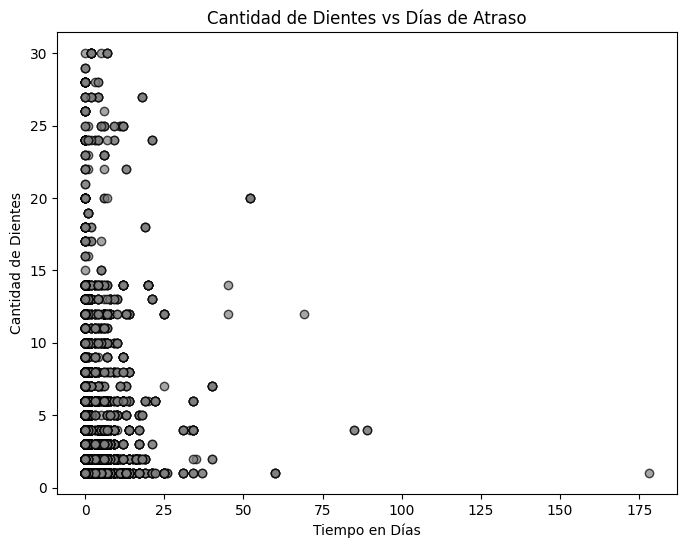

In [53]:
# Crear el scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

# Dibujar los puntos sin colores basados en "Atrasado"
scatter = ax.scatter(df_filtrado["Días de Atraso"], df_filtrado["Ctd"], color='gray', alpha=0.7, edgecolor='k')

# Añadir títulos y etiquetas
ax.set_title('Cantidad de Dientes vs Días de Atraso')
ax.set_xlabel('Tiempo en Días')
ax.set_ylabel('Cantidad de Dientes')

# Mostrar el gráfico
plt.show()

In [54]:
# Contar los registros donde 'Dias Pedido Total' es mayor a 18
pedidos_mas_18_dias = df_filtrado[df_filtrado['Dias Pedido Total'] > 18]

# Contar la cantidad de pedidos
cantidad_pedidos_mas_18_dias = pedidos_mas_18_dias['Nº'].nunique()

# Mostrar la cantidad de pedidos con más de 18 días
print(f"Cantidad de pedidos con más de 18 días en 'Dias Pedido Total': {cantidad_pedidos_mas_18_dias}")


Cantidad de pedidos con más de 18 días en 'Dias Pedido Total': 0


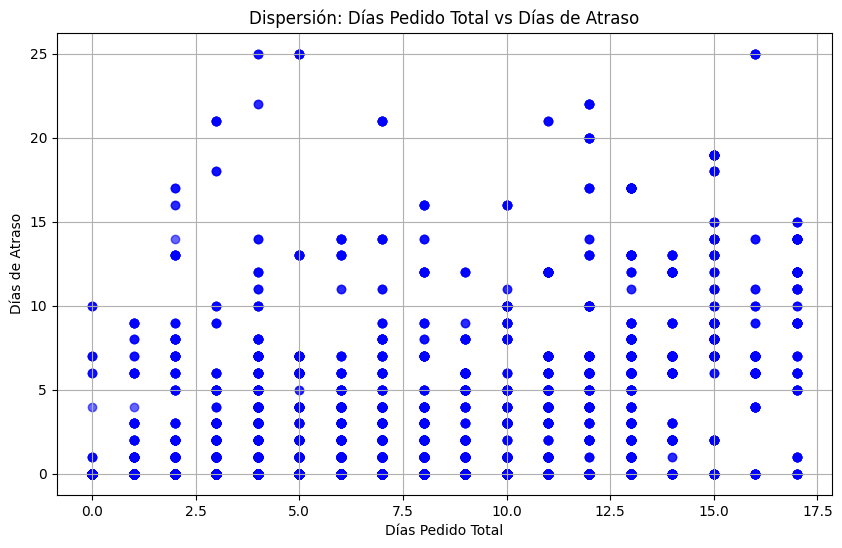

In [59]:
import matplotlib.pyplot as plt

# Crear el gráfico de dispersión para visualizar 'Dias Pedido Total' vs 'Días de Atraso'
plt.figure(figsize=(10, 6))
plt.scatter(df_filtrado['Dias Pedido Total'], df_filtrado['Días de Atraso'], color='blue', alpha=0.6)

# Agregar títulos y etiquetas
plt.title('Dispersión: Días Pedido Total vs Días de Atraso')
plt.xlabel('Días Pedido Total')
plt.ylabel('Días de Atraso')

# Mostrar el gráfico
plt.grid(True)
plt.show()

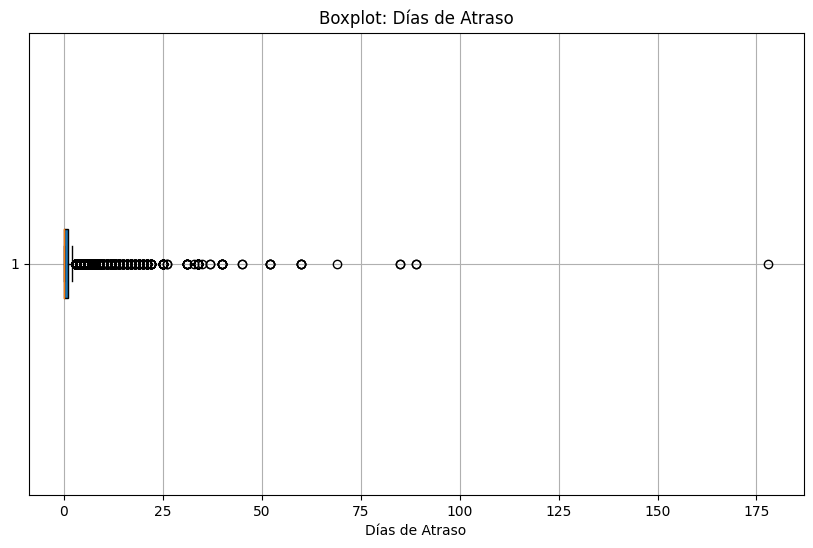

In [56]:
import matplotlib.pyplot as plt

# Crear el boxplot para visualizar la distribución de 'Días de Atraso'
plt.figure(figsize=(10, 6))

# Crear el boxplot para 'Días de Atraso'
plt.boxplot(df_filtrado['Días de Atraso'], vert=False, patch_artist=True)

# Agregar títulos y etiquetas
plt.title('Boxplot: Días de Atraso')
plt.xlabel('Días de Atraso')

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [57]:
import numpy as np

# Filtrar los registros donde 'Atrasado' sea 'SI' y los 'Días de Atraso' sean mayores a 0
pedidos_atrasados = df_filtrado[(df_filtrado['Atrasado'] == 'SI') & (df_filtrado['Días de Atraso'] > 0)]

# Calcular los cuartiles Q1 y Q3
Q1 = np.percentile(pedidos_atrasados['Días de Atraso'], 25)
Q3 = np.percentile(pedidos_atrasados['Días de Atraso'], 75)

# Calcular el rango intercuartílico (IQR)
IQR = Q3 - Q1

# Definir los límites para los outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar los outliers
outliers = pedidos_atrasados[(pedidos_atrasados['Días de Atraso'] < limite_inferior) | (pedidos_atrasados['Días de Atraso'] > limite_superior)]

# Contar cuántos outliers hay
cantidad_outliers = outliers.shape[0]

# Contar la cantidad total de pedidos atrasados
cantidad_pedidos_atrasados = pedidos_atrasados['Nº'].nunique()

# Mostrar el resultado
print(f"Cantidad de pedidos atrasados que son outliers: {cantidad_outliers}")
print(f"Cantidad total de pedidos atrasados: {cantidad_pedidos_atrasados}")


Cantidad de pedidos atrasados que son outliers: 192
Cantidad total de pedidos atrasados: 698


#### Borramos dias de atraso > 25

In [58]:
# Filtrar los registros donde 'Días de Atraso' sean menores o iguales a 25
df_filtrado = df_filtrado[df_filtrado['Días de Atraso'] <= 25]

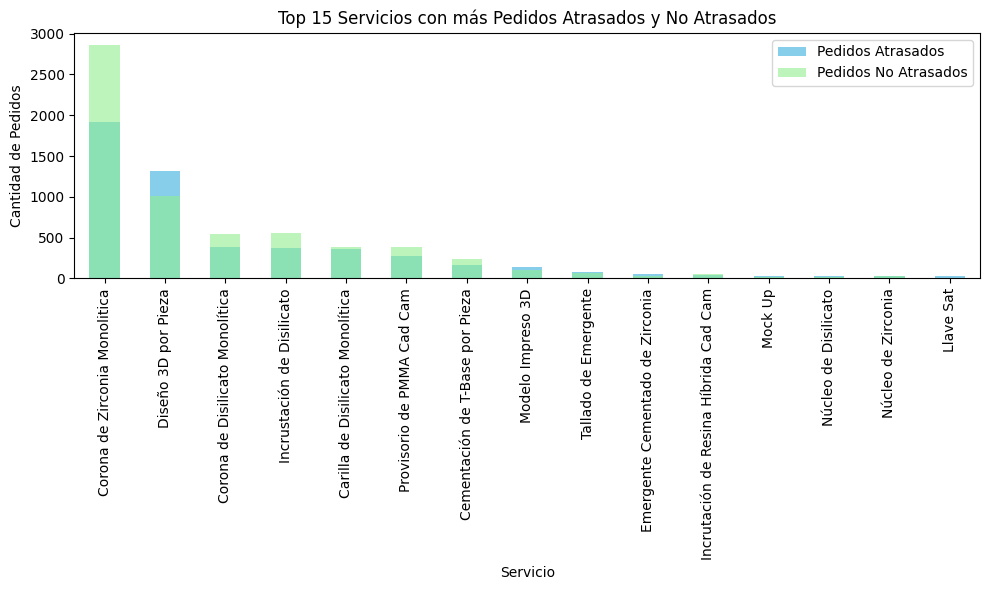

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar los pedidos que están atrasados
pedidos_atrasados = df_filtrado[df_filtrado['Atrasado'] == 'SI']

# Contar la cantidad de pedidos atrasados por servicio
pedidos_atrasados_por_servicio = pedidos_atrasados['Servicio'].value_counts()

# Contar la cantidad de pedidos no atrasados por servicio
pedidos_no_atrasados = df_filtrado[df_filtrado['Atrasado'] == 'NO']
pedidos_no_atrasados_por_servicio = pedidos_no_atrasados['Servicio'].value_counts()

# Crear un DataFrame con los resultados
servicios_atrasos = pd.DataFrame({
    'Cantidad de Pedidos Atrasados': pedidos_atrasados_por_servicio,
    'Cantidad de Pedidos No Atrasados': pedidos_no_atrasados_por_servicio
})

# Rellenar los valores faltantes con 0
servicios_atrasos.fillna(0, inplace=True)

# Mostrar los top 15 servicios con más atrasos
top_15_servicios = servicios_atrasos.nlargest(15, 'Cantidad de Pedidos Atrasados')

# Crear el gráfico de barras para los top 15 servicios con más atrasos
plt.figure(figsize=(10, 6))
top_15_servicios['Cantidad de Pedidos Atrasados'].plot(kind='bar', color='skyblue', label='Pedidos Atrasados')

# Añadir la cantidad de pedidos no atrasados como otra barra en el mismo gráfico
top_15_servicios['Cantidad de Pedidos No Atrasados'].plot(kind='bar', color='lightgreen', alpha=0.6, label='Pedidos No Atrasados')

# Agregar títulos y etiquetas
plt.title('Top 15 Servicios con más Pedidos Atrasados y No Atrasados')
plt.xlabel('Servicio')
plt.ylabel('Cantidad de Pedidos')
plt.legend()

# Rotar las etiquetas del eje X para mejor legibilidad
plt.xticks(rotation=90)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


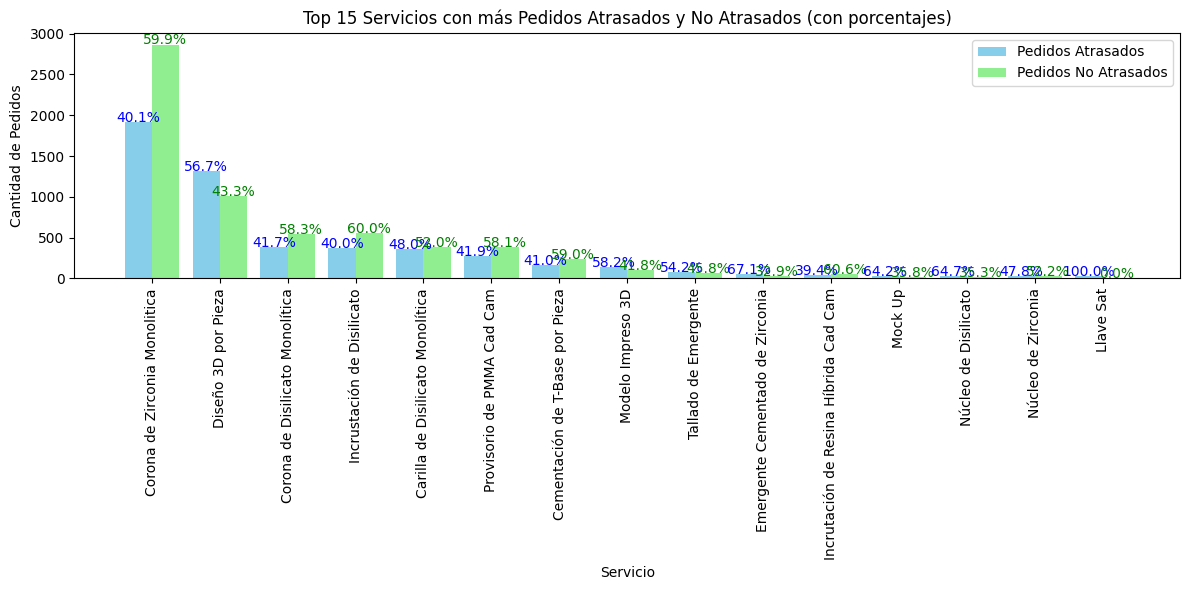

In [61]:
import matplotlib.pyplot as plt

# Crear el gráfico de barras agrupadas (side-by-side) para los top 15 servicios con más pedidos atrasados
plt.figure(figsize=(12, 6))

# Configurar ancho de las barras
width = 0.4

# Crear un array para la posición de las barras
ind = range(len(top_15_servicios))

# Gráfico de barras para los pedidos atrasados
plt.bar(ind, top_15_servicios['Cantidad de Pedidos Atrasados'], width, color='skyblue', label='Pedidos Atrasados')

# Gráfico de barras para los pedidos no atrasados, al lado
plt.bar([i + width for i in ind], top_15_servicios['Cantidad de Pedidos No Atrasados'], width, color='lightgreen', label='Pedidos No Atrasados')

# Calcular el porcentaje de atraso para cada servicio
top_15_servicios['Porcentaje Atrasados'] = (top_15_servicios['Cantidad de Pedidos Atrasados'] / 
                                            (top_15_servicios['Cantidad de Pedidos Atrasados'] + top_15_servicios['Cantidad de Pedidos No Atrasados'])) * 100
top_15_servicios['Porcentaje No Atrasados'] = 100 - top_15_servicios['Porcentaje Atrasados']

# Añadir el porcentaje de atrasos y no atrasos sobre las barras
for i in ind:
    plt.text(i, top_15_servicios['Cantidad de Pedidos Atrasados'].iloc[i] + 0.5, 
             f"{top_15_servicios['Porcentaje Atrasados'].iloc[i]:.1f}%", ha='center', color='blue')
    plt.text(i + width, top_15_servicios['Cantidad de Pedidos No Atrasados'].iloc[i] + 0.5, 
             f"{top_15_servicios['Porcentaje No Atrasados'].iloc[i]:.1f}%", ha='center', color='green')

# Agregar títulos y etiquetas
plt.title('Top 15 Servicios con más Pedidos Atrasados y No Atrasados (con porcentajes)')
plt.xlabel('Servicio')
plt.ylabel('Cantidad de Pedidos')
plt.xticks([i + width / 2 for i in ind], top_15_servicios.index, rotation=90)
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


#### Exportacion de datos limpios

In [62]:
print(df_filtrado.head())

     Nº Repetición|Ajuste  Cliente  Ctd                    Servicio  \
0  0099                 -        1    6         Diseño 3D por Pieza   
1  0099                 -        1    6         Diseño 3D por Pieza   
2  0099                 -        1    6         Diseño 3D por Pieza   
3  0163                 -        2    2  Incrustación de Disilicato   
4  0163                 -        2    2  Incrustación de Disilicato   

         Sector              Etapa  Empleado              Início  \
0        DISEÑO  DISEÑO DE SONRISA         1 2024-03-04 12:43:00   
1  IMPRESION 3D            ACABADO         1 2024-03-04 12:43:00   
2  IMPRESION 3D            MODELOS         2 2024-03-04 16:55:00   
3      CERAMICA         MAQUILLAJE         3 2023-11-02 12:40:00   
4      CERAMICA           GLASEADO         3 2023-11-02 12:41:00   

           Finalizado  ... Mes_de_entrada Día_de_la_semana_fecha_prevista  \
0 2024-03-06 17:15:00  ...        October                         Tuesday   
1 2024-03-

In [63]:
print(df_filtrado.columns)

Index(['Nº', 'Repetición|Ajuste', 'Cliente', 'Ctd', 'Servicio', 'Sector',
       'Etapa', 'Empleado', 'Início', 'Finalizado', 'Fecha entrada',
       'Fecha prevista', 'Horas Tarea Neto', 'Minutos Tarea Neto',
       'Días Tarea Neto', 'Horas Pedido Neto', 'Minutos Pedido Neto',
       'Días Pedido Neto', 'Dias Pedido Total', 'Última Finalización',
       'Atrasado', 'Días de Atraso', 'Día Semana Inicio',
       'Día Semana Finalización', 'promedio_horas_sector',
       'promedio_horas_sector_servicio', 'Promedio días atraso por sector',
       'Promedio días atraso por servicio', 'Tiempo_hasta_fecha_prevista',
       'Día_de_la_semana_entrada', 'Día_del_mes_entrada', 'Mes_de_entrada',
       'Día_de_la_semana_fecha_prevista', 'Día_del_mes_fecha_prevista',
       'Mes_de_fecha_prevista', 'duracion_trabajo', 'tiempo_promedio',
       'cantidad_etapas', 'desvio_fecha', 'carga_trabajo_sector',
       'carga_trabajo_total'],
      dtype='object')


In [65]:
print(df_filtrado.shape)

(12049, 41)


In [66]:
# Exportamos el DataFrame 'df' a un archivo CSV
df_filtrado.to_csv('df_limpio.csv', index=False)

# Confirmación de la operación
print("El archivo ha sido exportado exitosamente como 'df_limpio.csv'.")

El archivo ha sido exportado exitosamente como 'df_limpio.csv'.
